# __Importing the required libraries__

In [1]:
import torch
from torch import nn, utils, optim
from torchvision import datasets, transforms
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from copy import deepcopy
from tqdm.auto import tqdm
import numpy as np
import PIL
import os 

# __Counting training and validation images by category__

In [2]:
train_root = './drive/My Drive/Comp/dataset/train/'
val_root = './drive/My Drive/Comp/dataset/val/'

for category in os.listdir(train_root):
    print(f'{len(os.listdir(train_root + category))} training images for {category} category')
    print(f'{len(os.listdir(val_root + category))} validation images for {category} category\n')

167 training images for 4 category
40 validation images for 4 category

167 training images for 5 category
40 validation images for 5 category

167 training images for 6 category
40 validation images for 6 category

166 training images for 7 category
40 validation images for 7 category

164 training images for 9 category
40 validation images for 9 category

168 training images for 8 category
40 validation images for 8 category

165 training images for 0 category
40 validation images for 0 category

166 training images for 1 category
40 validation images for 1 category

166 training images for 2 category
40 validation images for 2 category

166 training images for 3 category
40 validation images for 3 category



# __Creating Training and Validation Data Loaders with Data Augmentation__

In [3]:
train_transform = transforms.Compose([transforms.Resize(64),
                                      transforms.CenterCrop(64),
                                      transforms.RandomHorizontalFlip(p = 0.5),
                                      lambda image: transforms.RandomRotation(20, resample = PIL.Image.BICUBIC, fill = int(0.85 * np.mean(image)))(image),
                                      transforms.Grayscale(num_output_channels = 1),
                                      transforms.ToTensor(),
                                      lambda image: (2 * image) - 1])

val_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.CenterCrop(64),
                                    transforms.Grayscale(num_output_channels = 1),
                                    transforms.ToTensor(),
                                    lambda image: (2 * image) - 1])

train_images = datasets.ImageFolder(root = train_root, transform = train_transform)
val_images = datasets.ImageFolder(root = val_root, transform = val_transform)

In [4]:
batch_size = 64
train_data = utils.data.DataLoader(train_images , batch_size = batch_size, shuffle = True)
val_data = utils.data.DataLoader(val_images , batch_size = 2 * batch_size, shuffle = False)

# __Visualizing Datasets__

In [5]:
def plot_images(images, titles, rescale, size = 14, shape = (6, 6)):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = (0.05, 0.4))
    for ax, image, title in zip(grid, deepcopy(images), titles):
        image = rescale(image)
        ax.imshow(image[0], cmap = 'gray_r')
        ax.axis('off')
        ax.set_title(title)
    plt.show()

Training features shape for single batch: torch.Size([64, 1, 64, 64])
Training labels shape for single batch: torch.Size([64])
Training features minimum value: -0.9843137264251709
Training features maximim value: 1.0
Training Images


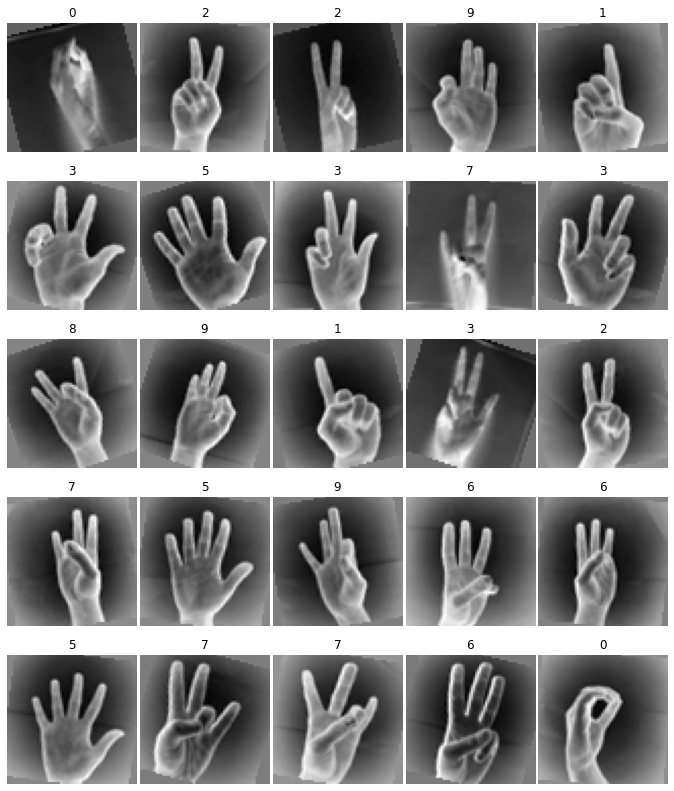

Validation features shape for single batch: torch.Size([128, 1, 64, 64])
Validation labels shape for single batch: torch.Size([128])
Validation features minimum value: -0.929411768913269
Validation features maximim value: 0.9764705896377563
Validation Images


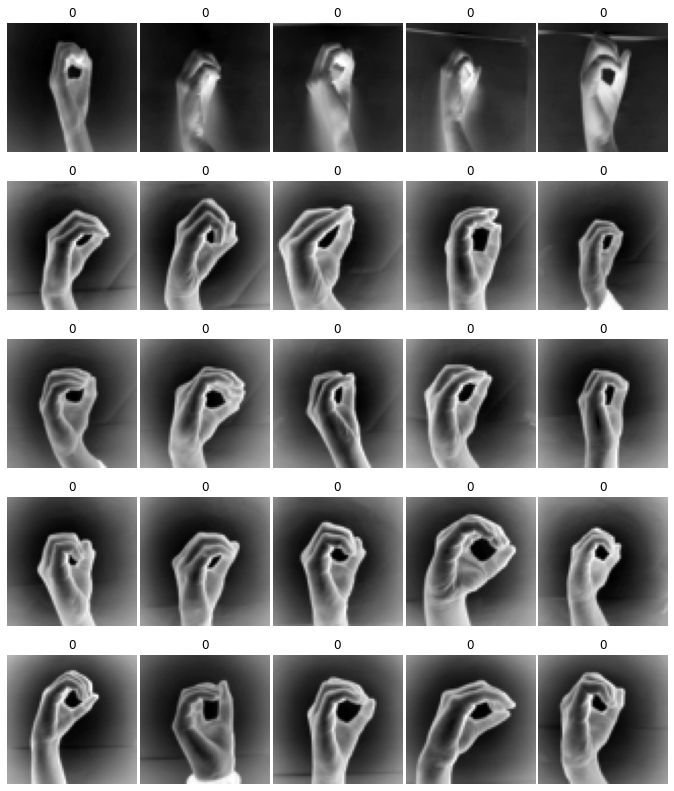

In [6]:
for x, y in train_data:
    break

print(f'Training features shape for single batch: {x.shape}')
print(f'Training labels shape for single batch: {y.shape}')
print(f'Training features minimum value: {x.min()}')
print(f'Training features maximim value: {x.max()}')

print('Training Images')
plot_images(x[:25], titles = [Y.item() for Y in y[:25]], shape = (5, 5), rescale = lambda image: 0.5 * (image + 1.0))

for x, y in val_data:
    break

print(f'Validation features shape for single batch: {x.shape}')
print(f'Validation labels shape for single batch: {y.shape}')
print(f'Validation features minimum value: {x.min()}')
print(f'Validation features maximim value: {x.max()}')

print('Validation Images')

plot_images(x[:25], titles = [Y.item() for Y in y[:25]], shape = (5, 5), rescale = lambda image: 0.5 * (image + 1.0))

# __Building the Model__

## __Convolutional Block__

In [7]:
def ConvBlock(input_channels, output_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1)
    )

## __Trainsition Block__

In [8]:
def TransitionBlock(input_channels, output_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(input_channels, output_channels, kernel_size = 1),
        nn.AvgPool2d(kernel_size = 2, stride = 2)
    )

## __Basic Dense Block__

In [9]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, output_channels):
        super(DenseBlock, self).__init__()
        
        blocks = []
        
        for i in range(num_convs):
            blocks.append(ConvBlock((output_channels * i) + input_channels, output_channels))

        self.model = nn.Sequential(*blocks)

    def forward(self, X):
        for block in self.model:
            Y = block(X)
            X = torch.cat((X, Y), dim = 1)
        return X

## __Feature Blocks__

In [10]:
output_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blocks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blocks.append(DenseBlock(num_convs, output_channels, growth_rate))
    output_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blocks.append(TransitionBlock(output_channels, output_channels // 2))
        output_channels = output_channels // 2

## __Creating the Full Architecture__

In [11]:
classifier = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    *blocks,
    nn.BatchNorm2d(output_channels),
    nn.LeakyReLU(0.2),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(output_channels, 10)
).cuda()

## Summarizing the Model

In [12]:
summary(classifier, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,200
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]          18,464
       BatchNorm2d-8           [-1, 96, 16, 16]             192
         LeakyReLU-9           [-1, 96, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]          27,680
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        LeakyReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]          36,896
      BatchNorm2d-14          [-1, 160,

## Visualizing the Model

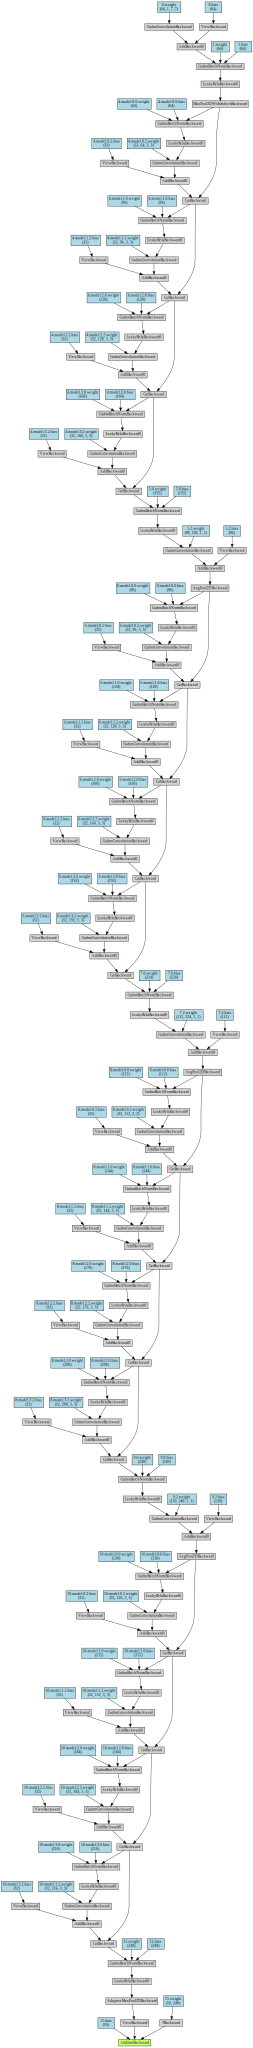

In [13]:
outputs = classifier(torch.zeros(1, 1, 64, 64).cuda())
make_dot(outputs, dict(classifier.named_parameters()))

# Defining objective loss and optimizer

In [14]:
batches = len(train_data)
epochs = 100

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr = 0.0001)

## Defining accuracy and validation function

In [15]:
accuracy = lambda outputs, labels: (outputs.argmax(1) == labels).float().mean()

def validate():
    cum_acc = 0.0
    classifier.eval()
    with torch.no_grad():
        for x, y in tqdm(val_data, desc = 'Validating'):
            outputs = classifier(x.cuda())
            cum_acc += accuracy(outputs, y.cuda())
    return 100.0 * (cum_acc.item() / len(val_data))

# __Training the Model__

In [16]:
best_val = 0.0

losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    classifier.train()

    ccum_loss = 0.0
    ccum_acc = 0.0

    for i, (features, labels) in enumerate(tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = '800px')):
        features = features.cuda()
        labels = labels.cuda()

        classifier.zero_grad()
        outputs = classifier(features)
        loss = objective(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            ccum_loss += loss.item()
            ccum_acc += accuracy(outputs, labels).item()
        
    val_acc = validate()

    losses.append(ccum_loss/batches)
    train_accs.append(ccum_acc/batches)
    val_accs.append(val_acc)

    print(f'Epoch: {epoch + 1}')
    print(f'Classifier Loss\t: {(ccum_loss/batches):.5f}')
    print(f'Classifier Training Accuracy\t: {(ccum_acc/batches) * 100:.5f}')
    print(f'Classifier Validation Accuracy\t: {val_acc:.5f}')

    if val_acc >= best_val:
        best_val = val_acc
        print('Best Validation Accuracy by far..............!')
        torch.save(classifier.state_dict(), 'classifier.pt')

    if loss != loss:
        print(f'Nan loss occured at: {epoch + 1}')
        break


Epoch: 1
Classifier Loss	: 1.79991
Classifier Training Accuracy	: 42.13904
Classifier Validation Accuracy	: 12.69531
Best Validation Accuracy by far..............!



Epoch: 2
Classifier Loss	: 1.05360
Classifier Training Accuracy	: 75.87236
Classifier Validation Accuracy	: 69.33594
Best Validation Accuracy by far..............!



Epoch: 3
Classifier Loss	: 0.70538
Classifier Training Accuracy	: 83.69456
Classifier Validation Accuracy	: 87.50000
Best Validation Accuracy by far..............!



Epoch: 4
Classifier Loss	: 0.52507
Classifier Training Accuracy	: 88.68448
Classifier Validation Accuracy	: 90.23438
Best Validation Accuracy by far..............!



Epoch: 5
Classifier Loss	: 0.40362
Classifier Training Accuracy	: 90.43114
Classifier Validation Accuracy	: 92.96875
Best Validation Accuracy by far..............!



Epoch: 6
Classifier Loss	: 0.33375
Classifier Training Accuracy	: 92.72061
Classifier Validation Accuracy	: 92.18750



Epoch: 7
Classifier Loss	: 0.27317
Classifier Training Accuracy	: 93.98457
Classifier Validation Accuracy	: 92.96875
Best Validation Accuracy by far..............!



Epoch: 8
Classifier Loss	: 0.22912
Classifier Training Accuracy	: 94.70960
Classifier Validation Accuracy	: 92.38281



Epoch: 9
Classifier Loss	: 0.20512
Classifier Training Accuracy	: 95.90958
Classifier Validation Accuracy	: 95.50781
Best Validation Accuracy by far..............!



Epoch: 10
Classifier Loss	: 0.17029
Classifier Training Accuracy	: 96.93122
Classifier Validation Accuracy	: 94.72656



Epoch: 11
Classifier Loss	: 0.14659
Classifier Training Accuracy	: 97.11538
Classifier Validation Accuracy	: 94.14062



Epoch: 12
Classifier Loss	: 0.15126
Classifier Training Accuracy	: 96.56676
Classifier Validation Accuracy	: 94.92188



Epoch: 13
Classifier Loss	: 0.14863
Classifier Training Accuracy	: 96.81103
Classifier Validation Accuracy	: 96.28906
Best Validation Accuracy by far..............!



Epoch: 14
Classifier Loss	: 0.12562
Classifier Training Accuracy	: 97.28986
Classifier Validation Accuracy	: 93.75000



Epoch: 15
Classifier Loss	: 0.10064
Classifier Training Accuracy	: 98.00907
Classifier Validation Accuracy	: 94.92188



Epoch: 16
Classifier Loss	: 0.09812
Classifier Training Accuracy	: 98.25721
Classifier Validation Accuracy	: 96.09375



Epoch: 17
Classifier Loss	: 0.09110
Classifier Training Accuracy	: 98.13314
Classifier Validation Accuracy	: 96.48438
Best Validation Accuracy by far..............!



Epoch: 18
Classifier Loss	: 0.08165
Classifier Training Accuracy	: 98.31537
Classifier Validation Accuracy	: 96.09375



Epoch: 19
Classifier Loss	: 0.06996
Classifier Training Accuracy	: 98.97837
Classifier Validation Accuracy	: 99.02344
Best Validation Accuracy by far..............!



Epoch: 20
Classifier Loss	: 0.06898
Classifier Training Accuracy	: 98.79808
Classifier Validation Accuracy	: 97.46094



Epoch: 21
Classifier Loss	: 0.06778
Classifier Training Accuracy	: 98.85623
Classifier Validation Accuracy	: 98.04688



Epoch: 22
Classifier Loss	: 0.06659
Classifier Training Accuracy	: 98.31731
Classifier Validation Accuracy	: 97.65625



Epoch: 23
Classifier Loss	: 0.06905
Classifier Training Accuracy	: 98.37740
Classifier Validation Accuracy	: 98.82812



Epoch: 24
Classifier Loss	: 0.05210
Classifier Training Accuracy	: 99.09662
Classifier Validation Accuracy	: 99.02344
Best Validation Accuracy by far..............!



Epoch: 25
Classifier Loss	: 0.04584
Classifier Training Accuracy	: 99.21681
Classifier Validation Accuracy	: 97.26562



Epoch: 26
Classifier Loss	: 0.05240
Classifier Training Accuracy	: 98.97449
Classifier Validation Accuracy	: 97.65625



Epoch: 27
Classifier Loss	: 0.04205
Classifier Training Accuracy	: 99.33894
Classifier Validation Accuracy	: 96.67969



Epoch: 28
Classifier Loss	: 0.04993
Classifier Training Accuracy	: 98.79614
Classifier Validation Accuracy	: 96.87500



Epoch: 29
Classifier Loss	: 0.03067
Classifier Training Accuracy	: 99.51923
Classifier Validation Accuracy	: 98.24219



Epoch: 30
Classifier Loss	: 0.03653
Classifier Training Accuracy	: 99.33894
Classifier Validation Accuracy	: 97.46094



Epoch: 31
Classifier Loss	: 0.03250
Classifier Training Accuracy	: 99.57933
Classifier Validation Accuracy	: 98.04688



Epoch: 32
Classifier Loss	: 0.03193
Classifier Training Accuracy	: 99.57933
Classifier Validation Accuracy	: 98.43750



Epoch: 33
Classifier Loss	: 0.03101
Classifier Training Accuracy	: 99.45913
Classifier Validation Accuracy	: 97.46094



Epoch: 34
Classifier Loss	: 0.04481
Classifier Training Accuracy	: 99.21100
Classifier Validation Accuracy	: 96.67969



Epoch: 35
Classifier Loss	: 0.04234
Classifier Training Accuracy	: 98.91827
Classifier Validation Accuracy	: 98.63281



Epoch: 36
Classifier Loss	: 0.02990
Classifier Training Accuracy	: 99.69952
Classifier Validation Accuracy	: 97.85156



Epoch: 37
Classifier Loss	: 0.02837
Classifier Training Accuracy	: 99.45720
Classifier Validation Accuracy	: 98.24219



Epoch: 38
Classifier Loss	: 0.02387
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 96.67969



Epoch: 39
Classifier Loss	: 0.02691
Classifier Training Accuracy	: 99.33700
Classifier Validation Accuracy	: 96.67969



Epoch: 40
Classifier Loss	: 0.03821
Classifier Training Accuracy	: 99.09856
Classifier Validation Accuracy	: 92.38281



Epoch: 41
Classifier Loss	: 0.04898
Classifier Training Accuracy	: 98.43556
Classifier Validation Accuracy	: 96.28906



Epoch: 42
Classifier Loss	: 0.03747
Classifier Training Accuracy	: 99.09856
Classifier Validation Accuracy	: 98.04688



Epoch: 43
Classifier Loss	: 0.03807
Classifier Training Accuracy	: 99.21875
Classifier Validation Accuracy	: 98.04688



Epoch: 44
Classifier Loss	: 0.02805
Classifier Training Accuracy	: 99.51729
Classifier Validation Accuracy	: 97.26562



Epoch: 45
Classifier Loss	: 0.03038
Classifier Training Accuracy	: 99.39904
Classifier Validation Accuracy	: 97.26562



Epoch: 46
Classifier Loss	: 0.02808
Classifier Training Accuracy	: 99.39904
Classifier Validation Accuracy	: 98.63281



Epoch: 47
Classifier Loss	: 0.02286
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 98.04688



Epoch: 48
Classifier Loss	: 0.02068
Classifier Training Accuracy	: 99.51923
Classifier Validation Accuracy	: 98.43750



Epoch: 49
Classifier Loss	: 0.01292
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 99.02344
Best Validation Accuracy by far..............!



Epoch: 50
Classifier Loss	: 0.01376
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.60938
Best Validation Accuracy by far..............!



Epoch: 51
Classifier Loss	: 0.01203
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.41406



Epoch: 52
Classifier Loss	: 0.01337
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.41406



Epoch: 53
Classifier Loss	: 0.01042
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 97.07031



Epoch: 54
Classifier Loss	: 0.01094
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.21875



Epoch: 55
Classifier Loss	: 0.01077
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.02344



Epoch: 56
Classifier Loss	: 0.01247
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 95.89844



Epoch: 57
Classifier Loss	: 0.01666
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 97.46094



Epoch: 58
Classifier Loss	: 0.01625
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 98.82812



Epoch: 59
Classifier Loss	: 0.01750
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 98.04688



Epoch: 60
Classifier Loss	: 0.01186
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 98.04688



Epoch: 61
Classifier Loss	: 0.01421
Classifier Training Accuracy	: 99.69758
Classifier Validation Accuracy	: 99.21875



Epoch: 62
Classifier Loss	: 0.01521
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 98.82812



Epoch: 63
Classifier Loss	: 0.01275
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.21875



Epoch: 64
Classifier Loss	: 0.01020
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 99.02344



Epoch: 65
Classifier Loss	: 0.01314
Classifier Training Accuracy	: 99.69952
Classifier Validation Accuracy	: 99.21875



Epoch: 66
Classifier Loss	: 0.01383
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 97.26562



Epoch: 67
Classifier Loss	: 0.01198
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 97.07031



Epoch: 68
Classifier Loss	: 0.01130
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.02344



Epoch: 69
Classifier Loss	: 0.00626
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 98.82812



Epoch: 70
Classifier Loss	: 0.00500
Classifier Training Accuracy	: 100.00000
Classifier Validation Accuracy	: 99.21875



Epoch: 71
Classifier Loss	: 0.00877
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 98.43750



Epoch: 72
Classifier Loss	: 0.01403
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 95.50781



Epoch: 73
Classifier Loss	: 0.01411
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 98.04688



Epoch: 74
Classifier Loss	: 0.01355
Classifier Training Accuracy	: 99.69952
Classifier Validation Accuracy	: 97.46094



Epoch: 75
Classifier Loss	: 0.00937
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.21875



Epoch: 76
Classifier Loss	: 0.00535
Classifier Training Accuracy	: 100.00000
Classifier Validation Accuracy	: 99.02344



Epoch: 77
Classifier Loss	: 0.01913
Classifier Training Accuracy	: 99.51729
Classifier Validation Accuracy	: 98.04688



Epoch: 78
Classifier Loss	: 0.01430
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 98.63281



Epoch: 79
Classifier Loss	: 0.01596
Classifier Training Accuracy	: 99.69758
Classifier Validation Accuracy	: 99.02344



Epoch: 80
Classifier Loss	: 0.02557
Classifier Training Accuracy	: 99.33700
Classifier Validation Accuracy	: 98.04688



Epoch: 81
Classifier Loss	: 0.02059
Classifier Training Accuracy	: 99.45913
Classifier Validation Accuracy	: 97.85156



Epoch: 82
Classifier Loss	: 0.00969
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 99.02344



Epoch: 83
Classifier Loss	: 0.00635
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.21875



Epoch: 84
Classifier Loss	: 0.00743
Classifier Training Accuracy	: 100.00000
Classifier Validation Accuracy	: 98.43750



Epoch: 85
Classifier Loss	: 0.00654
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 98.82812



Epoch: 86
Classifier Loss	: 0.00526
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 99.41406



Epoch: 87
Classifier Loss	: 0.00644
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 99.41406



Epoch: 88
Classifier Loss	: 0.00339
Classifier Training Accuracy	: 100.00000
Classifier Validation Accuracy	: 99.21875



Epoch: 89
Classifier Loss	: 0.00962
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.02344



Epoch: 90
Classifier Loss	: 0.00548
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 98.63281



Epoch: 91
Classifier Loss	: 0.00676
Classifier Training Accuracy	: 99.87981
Classifier Validation Accuracy	: 99.02344



Epoch: 92
Classifier Loss	: 0.02288
Classifier Training Accuracy	: 99.33894
Classifier Validation Accuracy	: 98.63281



Epoch: 93
Classifier Loss	: 0.01690
Classifier Training Accuracy	: 99.75962
Classifier Validation Accuracy	: 98.24219



Epoch: 94
Classifier Loss	: 0.01204
Classifier Training Accuracy	: 99.69952
Classifier Validation Accuracy	: 98.63281



Epoch: 95
Classifier Loss	: 0.01472
Classifier Training Accuracy	: 99.63748
Classifier Validation Accuracy	: 97.85156



Epoch: 96
Classifier Loss	: 0.01803
Classifier Training Accuracy	: 99.63942
Classifier Validation Accuracy	: 95.89844



Epoch: 97
Classifier Loss	: 0.02703
Classifier Training Accuracy	: 99.27885
Classifier Validation Accuracy	: 98.43750



Epoch: 98
Classifier Loss	: 0.01427
Classifier Training Accuracy	: 99.69952
Classifier Validation Accuracy	: 99.21875



Epoch: 99
Classifier Loss	: 0.01081
Classifier Training Accuracy	: 99.81971
Classifier Validation Accuracy	: 99.60938
Best Validation Accuracy by far..............!



Epoch: 100
Classifier Loss	: 0.00839
Classifier Training Accuracy	: 99.93990
Classifier Validation Accuracy	: 98.82812


# Reloading the best saved parameters

In [17]:
classifier.load_state_dict(torch.load('./classifier.pt'))

<All keys matched successfully>

# Final Validation Accuracy

In [18]:
validate()

99.609375

# __Visualizing Model Training Progress__

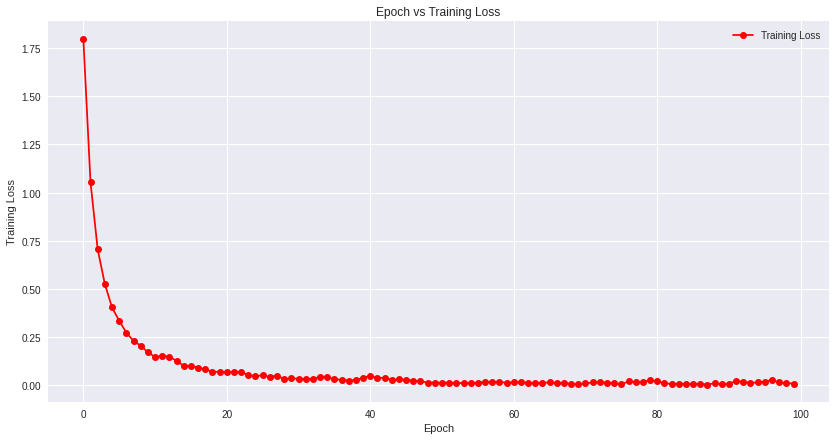

In [24]:
plt.style.use('seaborn')

plt.figure(figsize = (14, 7))
plt.plot(losses, marker = 'o', c = 'r', label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Epoch vs Training Loss')
plt.legend()
plt.show()

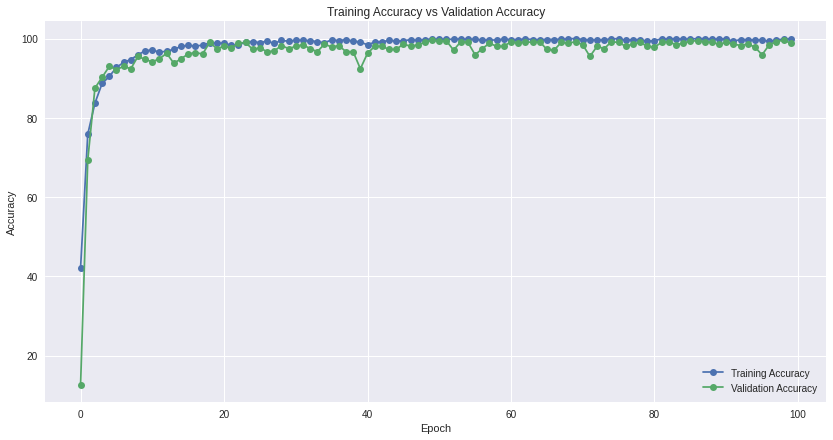

In [25]:
plt.figure(figsize = (14, 7))
plt.plot([100.0 * train_acc for train_acc in train_accs], marker = 'o', label = 'Training Accuracy')
plt.plot(val_accs, marker = 'o', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.show()